In [1]:
import glob
import os
import time
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from tensorflow import keras

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
batch_size = 128

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.astype('float32')
x_test = x_test / 255.
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).\
shuffle(60000).batch(128)

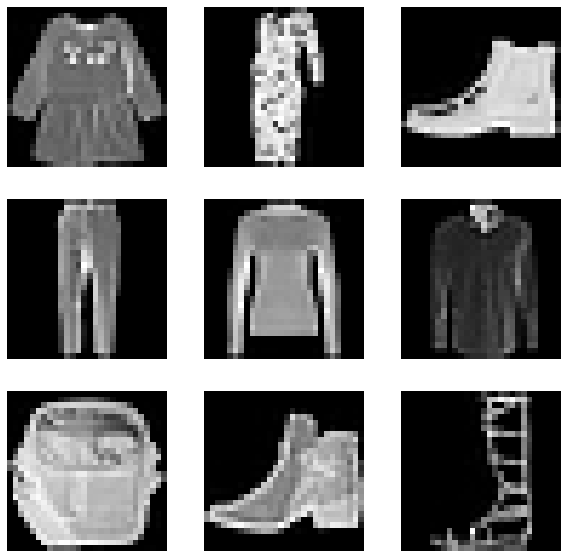

In [5]:
plt.figure(figsize=(10, 10))
for images in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i,:,:,0].numpy().astype("uint8"), cmap='gray')
        plt.axis("off")

In [6]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./255)

In [7]:
normalized_ds = train_dataset.map(lambda x: normalization_layer(x))
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [8]:
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [9]:
input_encoder = (28, 28, 1)
input_decoder = (2,)

In [10]:
def encoder(input_encoder):
    
    inputs = keras.Input(shape=input_encoder, name='input_layer')
    x = layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
    #x = layers.Dropout(rate = 0.25)(x)
    
    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    #x = layers.Dropout(rate = 0.25)(x)
    
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
    #x = layers.Dropout(rate = 0.25)(x)

    x = layers.Conv2D(64, 3, 1, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
    #x = layers.Dropout(rate = 0.25)(x)
    
    flatten = layers.Flatten()(x)
    bottleneck = layers.Dense(2, name='dense_1')(flatten)
    model = tf.keras.Model(inputs, bottleneck, name="Encoder")
    return model

In [11]:
enc = encoder(input_encoder)

In [12]:
enc.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 28, 28, 32)        128       
_________________________________________________________________
lrelu_1 (LeakyReLU)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 14, 14, 64)        18496     
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 14, 14, 64)        256       
_________________________________________________________________
lrelu_2 (LeakyReLU)          (None, 14, 14, 64)        0   

In [13]:
def decoder(input_decoder):
    
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(3136, name='dense_1')(inputs)
    #x = tf.reshape(x, [-1, 7, 7, 64], name='Reshape_Layer')
    x = layers.Reshape((7,7,64), name='Reshape_Layer')(x)
    x = layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
    #x = layers.Dropout(rate = 0.25)(x)
    
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    #x = layers.Dropout(rate = 0.25)(x)
    
    x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
    #x = layers.Dropout(rate = 0.25)(x)
    
    outputs = layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model

In [14]:
dec = decoder(input_decoder)

In [15]:
dec.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
Reshape_Layer (Reshape)      (None, 7, 7, 64)          0         
_________________________________________________________________
conv_transpose_1 (Conv2DTran (None, 7, 7, 64)          36928     
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 7, 7, 64)          256       
_________________________________________________________________
lrelu_1 (LeakyReLU)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv_transpose_2 (Conv2DTran (None, 14, 14, 64)        3692

In [19]:
# dec.save('ae-dec-fashion.h5')
# enc.save('ae-enc-fashion.h5')

In [20]:
#dec.summary()

In [21]:
#model.layers[1].get_weights()

In [22]:
#model.save('autoencoder.h5')

In [16]:
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)

In [17]:
from tensorflow.keras import backend as K

In [18]:
def ae_loss(y_true, y_pred):
    loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return loss

In [19]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):

    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
      
        latent = enc(images, training=True)
        generated_images = dec(latent, training=True)
        loss = ae_loss(images, generated_images)
        
    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)
    
    
    optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    return loss

In [20]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        loss_ = []
        for image_batch in dataset:
            i += 1
            loss = train_step(image_batch)
            #loss_.append(loss)

        #print("Loss",np.mean(loss_))    
        seed = image_batch[:25]
        display.clear_output(wait=True)
        generate_and_save_images([enc,dec],
                              epoch + 1,
                              seed)
        # Save the model every 15 epochs
        #if (epoch + 1) % 15 == 0:
        #checkpoint.save(file_prefix = checkpoint_prefix)
        enc.save_weights('tf_ae/fashion/training_weights/enc_'+ str(epoch)+'.h5')
        dec.save_weights('tf_ae/fashion/training_weights/dec_'+ str(epoch)+'.h5')
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images([enc,dec],
                            epochs,
                            seed)

In [21]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    latent = enc(test_input, training=False)
    predictions = dec(latent, training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 255, cmap='gray')
        plt.axis('off')

    plt.savefig('tf_ae/fashion/images/image_at_epoch_{:d}.png'.format(epoch))
    plt.show()

(25, 28, 28, 1)


FileNotFoundError: [Errno 2] No such file or directory: 'tf_ae/fashion/images/image_at_epoch_1.png'

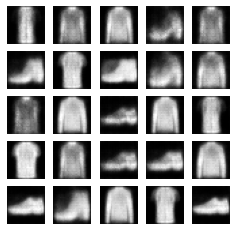

In [22]:
train(normalized_ds, 40)

In [ ]:
enc.load_weights('./tf_ae/fashion/training_weights/enc_39.h5')

In [ ]:
dec.load_weights('./tf_ae/fashion/training_weights/dec_39.h5')

In [ ]:
embeddings = None
for i in normalized_ds:
    embed = encoder_model.predict(i)
    if embeddings is None:
        embeddings = embed
    else:
        embeddings = np.concatenate((embeddings, embed))
    if embeddings.shape[0] > 5000:
        break

In [ ]:
n_to_show = 5000
figsize = 10

index = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[index]

embeddings = enc.predict(example_images)


plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0] , embeddings[:, 1], alpha=0.5, s=2)
plt.xlabel("Dimension-1", size=20)
plt.ylabel("Dimension-2", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Projection of 2D Latent-Space (Fashion-MNIST)", size=20)
plt.show()

In [ ]:
min_x = min(embeddings[:, 0])
max_x = max(embeddings[:, 0])
min_y = min(embeddings[:, 1])
max_y = max(embeddings[:, 1])

In [ ]:
# Create dictionary of target classes
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot',
}

In [ ]:
figsize = 15

latent = enc.predict(x_test[:25])
reconst = dec.predict(latent)

fig = plt.figure(figsize=(figsize, 10))
#fig.subplots_adjust(wspace=-0.021)

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    plt.text(0.5, -0.15, str(label_dict[y_test[i]]), fontsize=15, ha='center', transform=ax.transAxes)
    #plt.subplots_adjust(wspace=None, hspace=None)
    plt.imshow(reconst[i, :,:,0]*255, cmap = 'gray')
plt.show()    

## Reconstructing Fashion Images with Latent-Vector Sampled Uniformly

In [ ]:
min_x = min(embeddings[:, 0])
max_x = max(embeddings[:, 0])
min_y = min(embeddings[:, 1])
max_y = max(embeddings[:, 1])

x = np.random.uniform(low=min_x,high=max_x, size = (10,1))
y = np.random.uniform(low=min_y,high=max_y, size = (10,1))
bottleneck = np.concatenate((x, y), axis=1)
reconst = dec.predict(bottleneck)

fig = plt.figure(figsize=(15, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.text(0.5, -0.15, str(np.round(bottleneck[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0]*255, cmap = 'gray')